<a href="https://colab.research.google.com/github/bliits/Dota2_Statistics/blob/main/dota2_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1. Extraction and preprocessing of data.

In [ ]:
!pip install fake-useragent
!pip install pyopendota

In [ ]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import time
import opendota
import seaborn as sns
import time
import requests

First of all we need get an access to information from matches. One of the possible ways is to use Dota API. Official website writes that:

> The OpenDota API provides Dota 2 related data including advanced match data extracted from match replays. You can find data that can be used to convert hero and ability IDs and other information provided by the API from the dotaconstants repository.

So, for start, we need extract a list of Dota 2 heroes with their unique IDs. We will use official resourse DotaBuff with the latest data.

In [ ]:
### Dota 2 heroes list
user_agent = {'User-Agent': UserAgent().random}
client = opendota.OpenDota()
#
heroes_list = {'id': [],
               'hero_name': []}
url = 'https://www.dotabuff.com/heroes'
#
page = requests.get(url,headers=user_agent)
soup = BeautifulSoup(page.text, 'lxml')
#
records = soup.find("div",class_="content-inner")
records = soup.find("div",class_="hero-grid")
records = records.findAll("a")
#
for ii in range(0, len(records)):
    heroes_list['id'].append(ii)
    heroes_list['hero_name'].append(records[ii].find('div', class_="name").text)
#
heroes_list = pd.DataFrame(heroes_list)
heroes_list['id'] = heroes_list['hero_name'].apply(lambda x: client.search_hero(x)[0]['id'])

In [ ]:
heroes_list.head()

,id,hero_name
0,102,Abaddon
1,73,Alchemist
2,68,Ancient Apparition
3,1,Anti-Mage
4,113,Arc Warden


Second step is extract heroes icons (for better vizualization). We will use fan webresourse https://dota2.fandom.com with necessary data.

In [ ]:
url = 'https://dota2.fandom.com/wiki/Minimap'
#
page = requests.get(url,headers=user_agent)
soup = BeautifulSoup(page.text, 'lxml')
#
records = soup.find("table",class_="wikitable")
records = records.findAll("a")
#
for ii in range(0, len(records)):
    link_url = re.search(r'data-src="(.*?)"', str(records[ii])).group(1)
    img_data = requests.get(link_url).content
    with open(re.search(r'img alt="(.*?)" class="', str(records[ii])).group(1)+'.jpg', 'wb') as handler:
        handler.write(img_data)

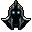

In [ ]:
from PIL import Image

Image.open(r'/content/Abaddon minimap icon.jpg')

Third step is extraction of some number of matches for each tier (for better understanding of heroes statistics). Ranks in OpenDota are represented by integers:

    10-15: Herald
    20-25: Guardian
    30-35: Crusader
    40-45: Archon
    50-55: Legend
    60-65: Ancient
    70-75: Divine
    80-85: Immortal

So, according to OpenDota limits ("Without a key, you can make 2,000 free calls per day at a rate limit of 60 requests/minute") we will take for 300 matches for each rank (besides Immortal).

In [ ]:
match_list = pd.DataFrame()
match_inform = pd.DataFrame()
matches_info = pd.DataFrame()
#
main_stats = ['hero_id',
              'hero_damage',
              'tower_damage',
              'hero_healing',
              'total_gold',
              'total_xp']
intervals = {'Herald':  np.arange(10,16),
             'Guardian':np.arange(20,26),
             'Crusader':np.arange(30,36),
             'Archon':  np.arange(40,46),
             'Legend':  np.arange(50,56),
             'Ancient': np.arange(60,66),
             'Divine':  np.arange(70,76),
             'Immortal':np.arange(80,86)}
#
for key in list(intervals):
    for numb in range(len(intervals[key])-1):
        time_step = pd.DataFrame(client.request("/publicMatches",
                                                data={'min_rank':intervals[key][numb],
                                                      'max_rank':intervals[key][numb+1]}))
        time_step['avg_rank_tier'] = time_step['avg_rank_tier'].apply(lambda x: key+' '+str(x%10))
        match_list = pd.concat([match_list, time_step], axis=0, ignore_index=True)
        for numb_of_m in range(time_step.shape[0]):
            match_inform = pd.DataFrame(client.get_match(time_step['match_id'].iloc[numb_of_m])['players'])
            match_inform = match_inform[np.array(main_stats)[np.isin(main_stats,match_inform.columns)]]
            match_inform['match_id'] = time_step['match_id'].iloc[numb_of_m]
            matches_info = pd.concat([matches_info,match_inform],axis=0,ignore_index=True)
#
matches_info = matches_info.dropna()
matches_info = matches_info.drop_duplicates(ignore_index=True)

In [ ]:
match_list.head()

,match_id,match_seq_num,radiant_win,start_time,duration,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster,radiant_team,dire_team
0,7685808305,6469430846,True,1713099234,1418,0,4,Herald 1,4,152,"[102, 98, 31, 1, 18]","[53, 66, 2, 8, 7]"
1,7682828202,6466882436,True,1712944218,2029,7,22,Herald 1,3,271,"[65, 72, 85, 34, 27]","[19, 102, 82, 78, 75]"
2,7680556115,6464945526,True,1712822476,1835,0,22,Herald 1,2,153,"[12, 98, 81, 27, 21]","[28, 17, 41, 30, 84]"
3,7680032817,6464475173,True,1712777327,1073,7,22,Herald 1,2,184,"[105, 46, 41, 26, 99]","[68, 67, 20, 1, 136]"
4,7679550415,6464065197,False,1712757436,1368,0,22,Herald 1,2,154,"[20, 17, 6, 84, 129]","[54, 13, 14, 73, 28]"


In [ ]:
matches_info.iloc[5:15]

,hero_id,hero_damage,tower_damage,hero_healing,total_gold,total_xp,match_id
5,53,6160.0,0.0,125.0,5341,5128,7685808305
6,66,4153.0,0.0,2089.0,5672,6428,7685808305
7,2,5925.0,0.0,0.0,6900,5931,7685808305
8,8,9937.0,0.0,929.0,9169,10020,7685808305
9,7,9256.0,0.0,0.0,6971,5577,7685808305
10,65,69141.0,6077.0,0.0,25937,40884,7682828202
11,72,46388.0,11918.0,0.0,25396,40072,7682828202
12,85,18094.0,564.0,940.0,13019,18159,7682828202
13,34,17749.0,550.0,0.0,13594,18869,7682828202
14,27,15169.0,985.0,192.0,11835,17111,7682828202


Using Python we extracted all neccessary data and form three datasets:
'heroes.csv' - heroes IDs and names
'match_list.csv' - list of matches (per tiers) with general information
'matches_info.csv' - data for each hero in every match from 'match_list.csv'

The next step is to use SQL to get statistics data.

# Part 2. SQL operations to obtain average statistics.

Right now, we need to use SQL to compute the next statistics data:

1.   Count the number of each hero across all matches
2.   Count the number of each hero for every tier
3.   Duration of match (based on all matches)
4.   Duration of match (for each tier)
5.   Total hero damage \ tower damage \ hero healing
6.   Total earned gold \ experience

We will use BiqQuery to compute every item from the list.

SQL code for:
1. Count the number of each hero across all matches

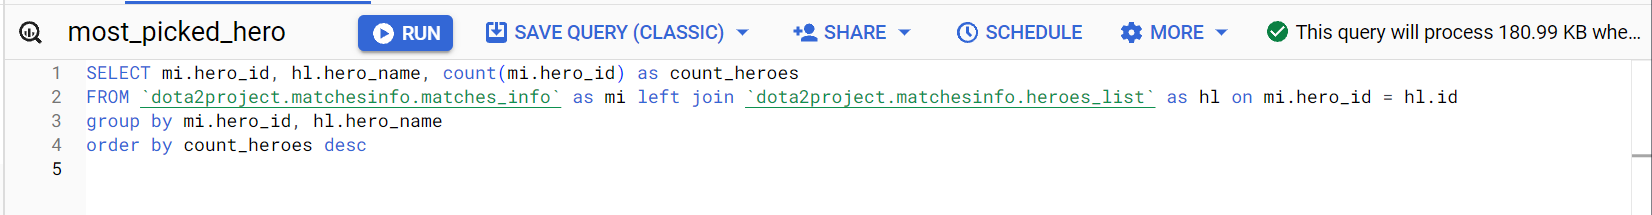

and Output:

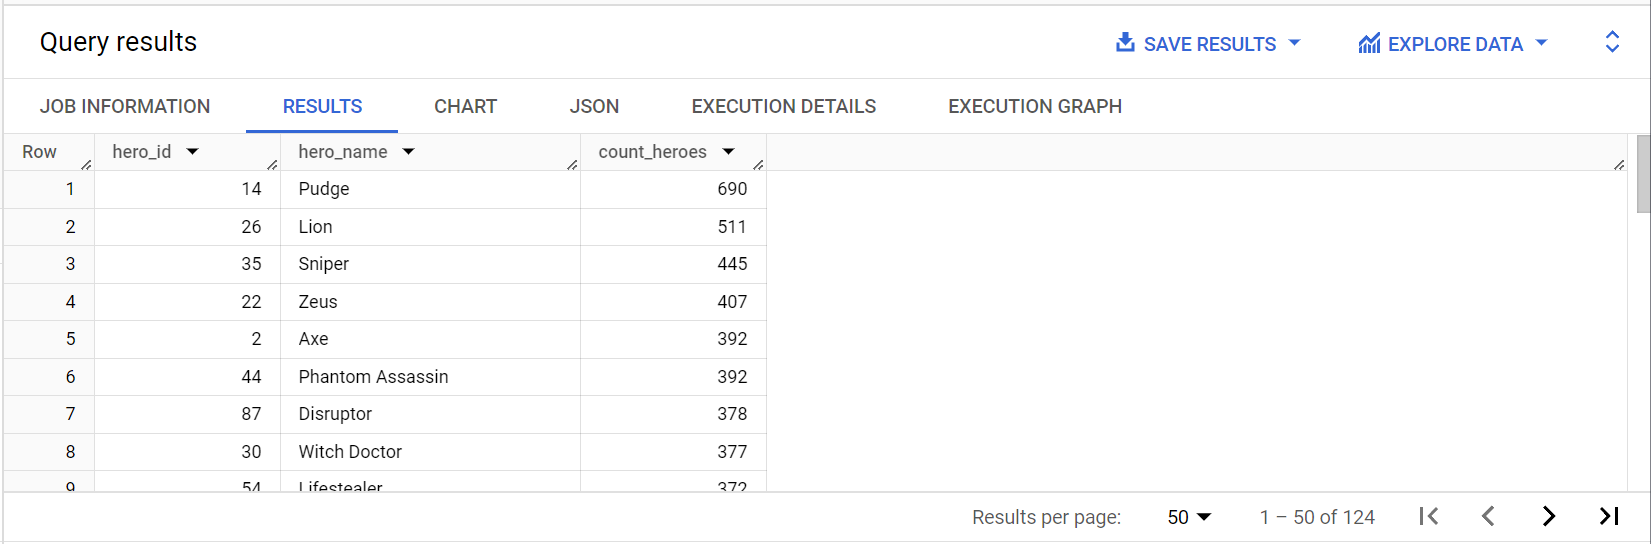

SQL code for:

2. Count the number of each hero for every tier

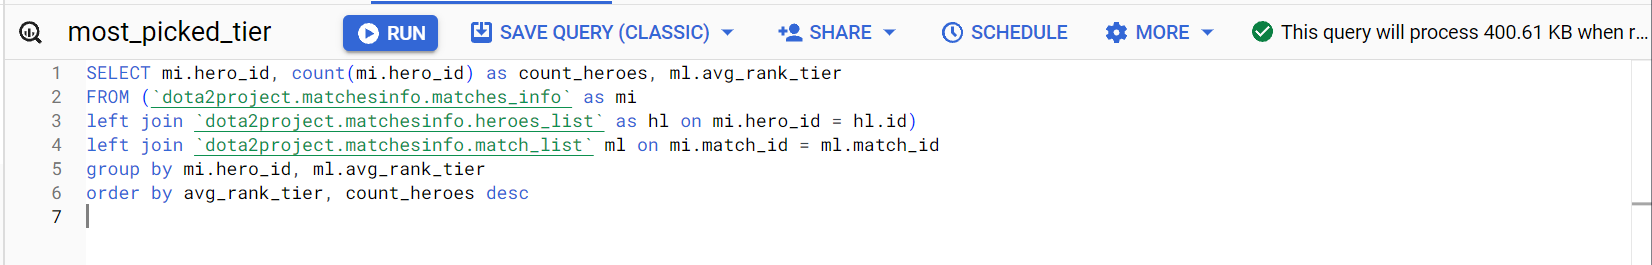

and Output:

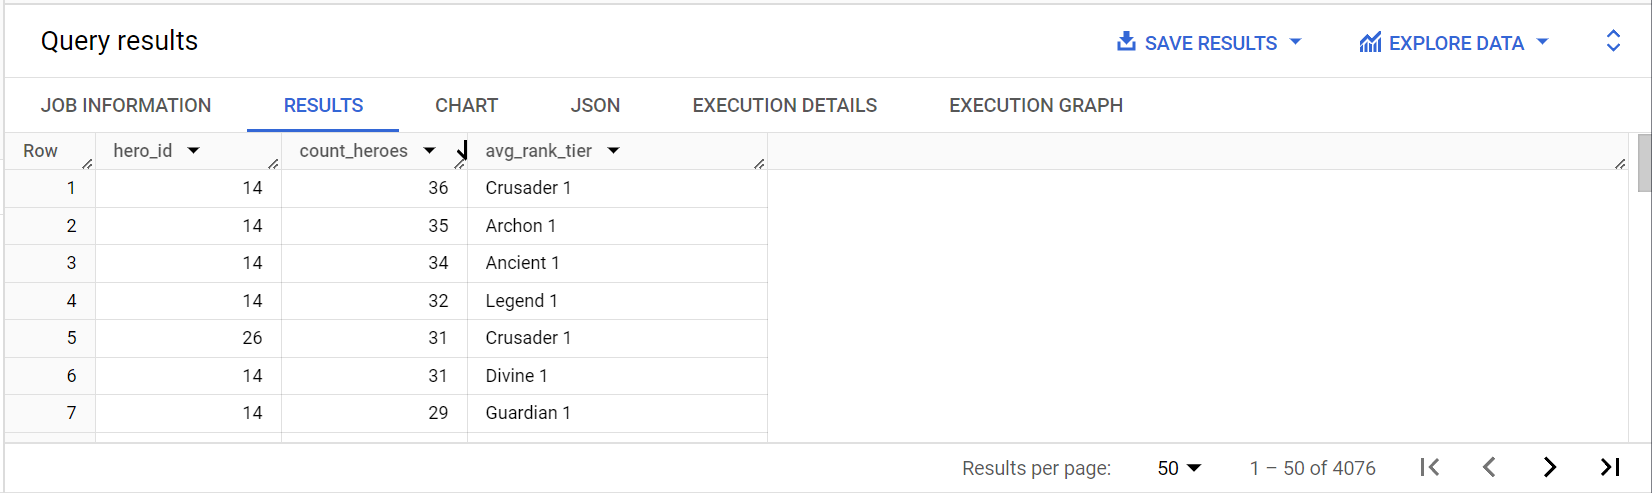

For "Duration of match (based on all matches)" and "Duration of match (for each tier)" we can use csv-file "match_list", where shown duration for each match and every tier.

SQL code for:

5. Total hero damage \ tower damage \ hero healing

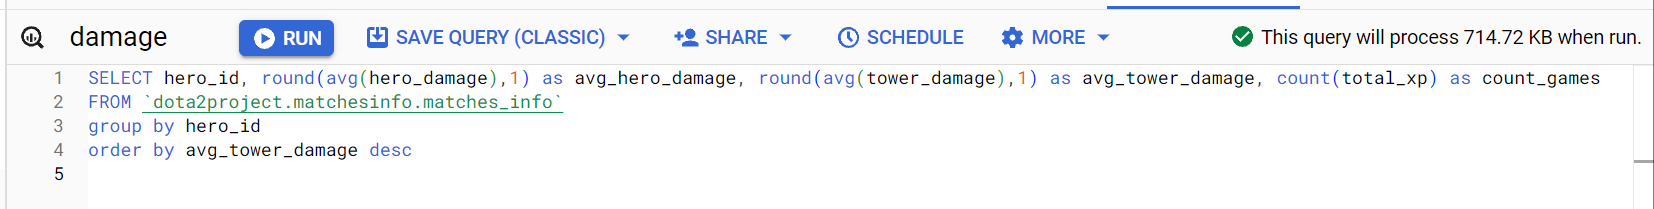

and Output:

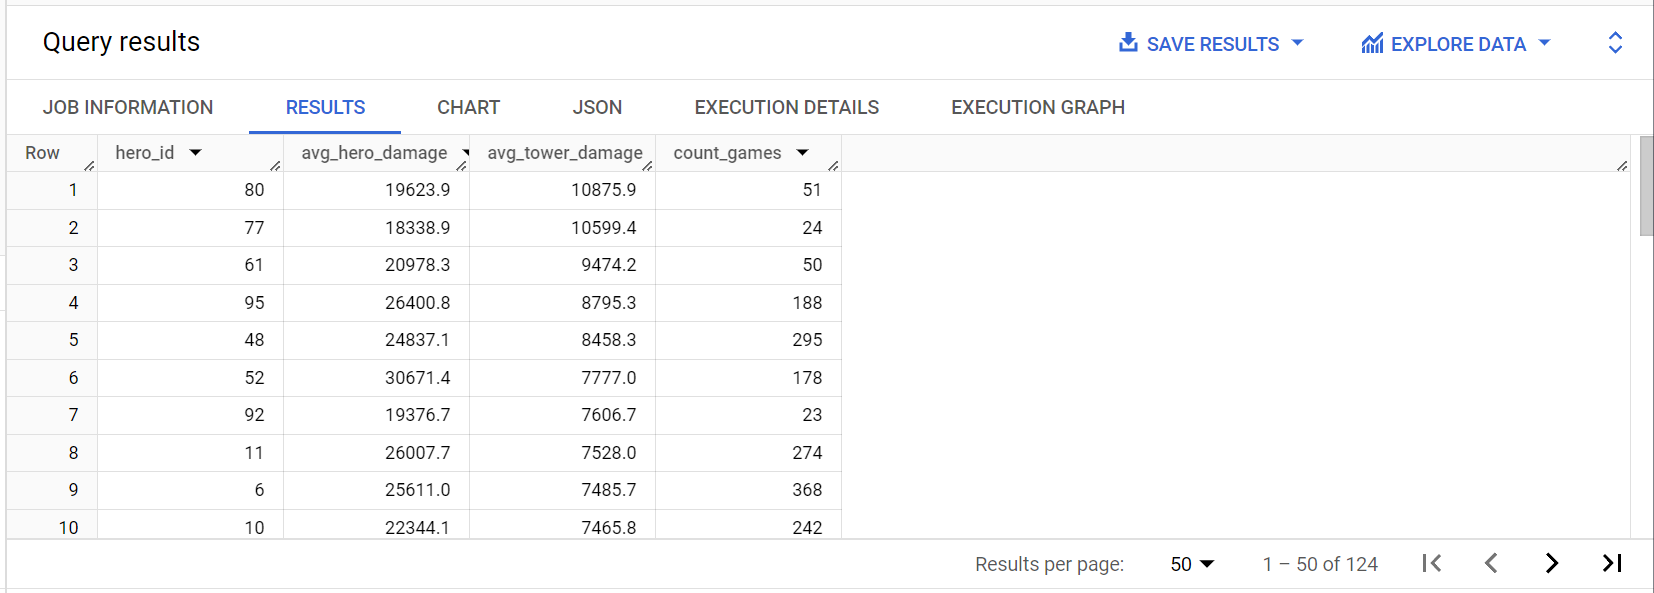

SQL code for:

6. Total earned gold \ experience

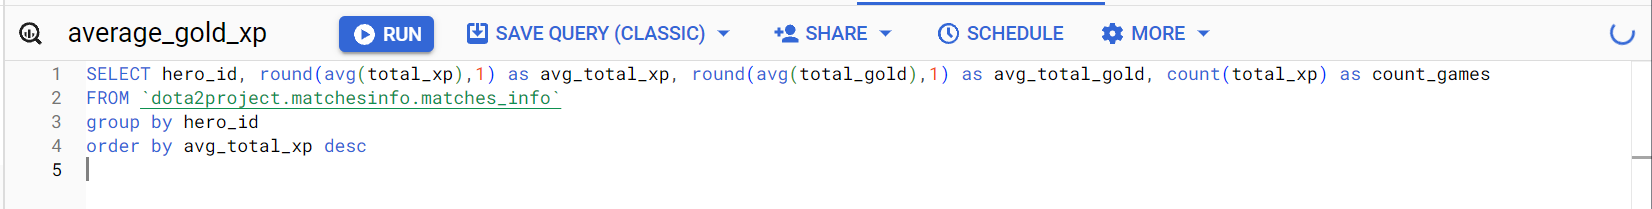

and Output:

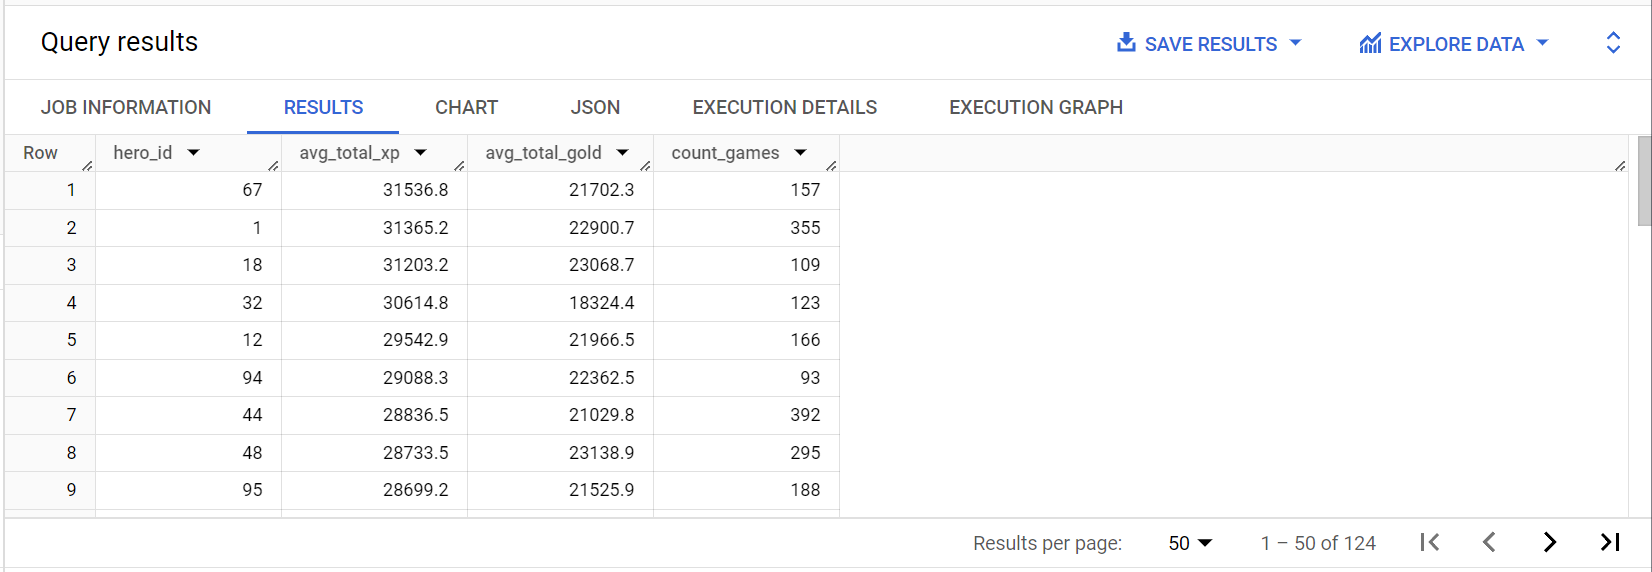

All results we saved in separate files and will use them to create dashboard in Tableau Public. To view these Tableau Dashboards in Tableau Public, click on the hypertext link
[Dota 2 Project](https://public.tableau.com/app/profile/dmytro.shevchuk/viz/Dota2_project/Dashboard1#1).


# Part 3. Data Vizualization in Tableau Public

In [ ]:
from IPython.core.display import HTML
HTML("<div class='tableauPlaceholder' id='viz1713640065809' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Do&#47;Dota2_project&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Dota2_project&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Do&#47;Dota2_project&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1713640065809');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='2077px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>")